In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
import pandas as pd
from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


### Get the CESM tseries files 

In [2]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.zoo4longlived2'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'
variables = ['PD','x_graze_zoo1_zint','x_graze_zoo2_zint',
            'x_graze_zoo3_zint','x_graze_zoo4_zint','photoC_TOT_zint', 'photoC_diat_zint']

In [3]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.annual.{v}.????-????.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.zoo4longlived2
PD
x_graze_zoo1_zint
x_graze_zoo2_zint
x_graze_zoo3_zint
x_graze_zoo4_zint
photoC_TOT_zint
photoC_diat_zint
CPU times: user 1.8 s, sys: 455 ms, total: 2.25 s
Wall time: 3.46 s


In [4]:
ds

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320, time: 20, z_t: 60)
Coordinates:
    TLONG              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t                (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * time               (time) object 0042-12-31 00:00:00 ... 0061-12-31 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT                (time, nlat, nlon) float64 dask.array<chunksize=(20, 384, 320), meta=np.ndarray>
    TAREA              (time, nlat, nlon) float64 dask.array<chunksize=(20, 384, 320), meta=np.ndarray>
    dz                 (time, z_t) float32 dask.array<chunksize=(20, 60), meta=np.ndarray>
    PD                 (time, z_t, nlat, nlon) float32 dask.array<chunksize=(20, 60, 384, 320), meta=np.ndarray>
    x_graze_zoo1_zint  (time, nlat, nlon) float32 dask.array<chunksize=(20, 384, 320), meta=np.ndarray>
    x_graze_zoo2_zint  (time, nlat, nlon) float32 dask.array<chunksize=(20, 384, 320), meta=np.ndarray>
    x_graze_zoo3_zint  (time, nlat, nlon) float32 dask.array<chunksize=(20, 384, 320), meta=np.ndarray>
    x_graze_zoo4_zint  (time, nlat, nlon) float32 dask.array<chunksize=(20, 384, 320), meta=np.ndarray>
    photoC_TOT_zint    (time, nlat, nlon) float32 dask.array<chunksize=(20, 384, 320), meta=np.ndarray>
    photoC_diat_zint   (time, nlat, nlon) float32 dask.array<chunksize=(20, 384, 320), meta=np.ndarray>

In [5]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4

ds['z_t']=ds_grid.z_t
depths_m=ds_grid.z_t * 0.01
dz=ds_grid.dz
dz_m=ds_grid.dz * 0.01
tlen=len(ds.time)
years = np.arange(1999,1999+tlen)

In [6]:
len(years)

20

In [7]:
sigma_surf = ds.PD.isel(z_t=0) * 1000. - 1000.

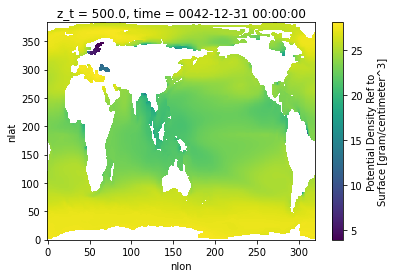

In [8]:
sigma_surf.isel(time=0).plot()

In [50]:
#make time-varying masks for sigma bounds 26 to 27 and >27 in Southern ocean
sigma_lt24 = sigma_surf.where(lats<50.).where(sigma_surf<24.).mean(dim='time')
sigma24to25 = sigma_surf.where(lats<0.).where(sigma_surf > 24.).where(sigma_surf<25.).mean(dim='time')
sigma25to26 = sigma_surf.where(lats<0.).where(sigma_surf > 25.).where(sigma_surf<26.).mean(dim='time')
sigma26to27 = sigma_surf.where(lats<0.).where(sigma_surf > 26.).where(sigma_surf<27.).mean(dim='time')
sigma_gt27 = sigma_surf.where(lats<0.).where(sigma_surf>27.).mean(dim='time')

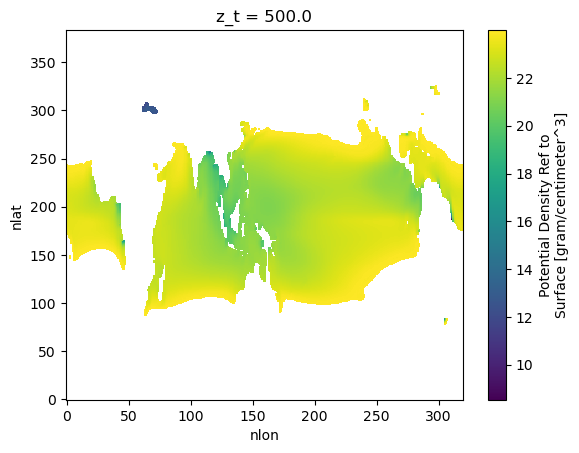

In [51]:
sigma_lt24.plot() #isel(time=0).plot()

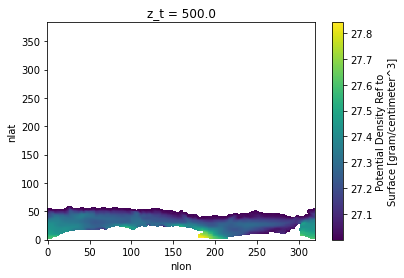

In [11]:
sigma_gt27.plot() #isel(time=0).plot()

In [12]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [13]:
ds['TOT_zoo_prod_zint'] = ds.x_graze_zoo1_zint + ds.x_graze_zoo2_zint + ds.x_graze_zoo3_zint + ds.x_graze_zoo4_zint

In [14]:
ds['z-ratio'] = ds.x_graze_zoo3_zint / ds.photoC_TOT_zint

In [15]:
ds

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320, time: 20, z_t: 60)
Coordinates:
    TLONG              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t                (z_t) float64 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * time               (time) object 0042-12-31 00:00:00 ... 0061-12-31 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT                (time, nlat, nlon) float64 dask.array<chunksize=(20, 384, 320), meta=np.ndarray>
    TAREA              (time, nlat, nlon) float64 dask.array<chunksize=(20, 384, 320), meta=np.ndarray>
    dz                 (time, z_t) float32 dask.array<chunksize=(20, 60), meta=np.ndarray>
    PD                 (time, z_t, nlat, nlon) float32 dask.array<chunksize=(20, 60, 384, 320), meta=np.ndarray>
    x_graze_zoo1_zint  (time, nlat, nlon) float32 dask.array<chunksize=(20, 384, 320), meta=np.ndarray>
    x_graze_zoo2_zint  (time, nlat, nlon) float32 dask.array<chunksize=(20, 384, 320), meta=np.ndarray>
    x_graze_zoo3_zint  (time, nlat, nlon) float32 dask.array<chunksize=(20, 384, 320), meta=np.ndarray>
    x_graze_zoo4_zint  (time, nlat, nlon) float32 dask.array<chunksize=(20, 384, 320), meta=np.ndarray>
    photoC_TOT_zint    (time, nlat, nlon) float32 dask.array<chunksize=(20, 384, 320), meta=np.ndarray>
    photoC_diat_zint   (time, nlat, nlon) float32 dask.array<chunksize=(20, 384, 320), meta=np.ndarray>
    TOT_zoo_prod_zint  (time, nlat, nlon) float32 dask.array<chunksize=(20, 384, 320), meta=np.ndarray>
    z-ratio            (time, nlat, nlon) float32 dask.array<chunksize=(20, 384, 320), meta=np.ndarray>

In [17]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.TOT_zoo_prod_zint.isel(time=10))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

In [18]:
sigma = sigma_surf.isel(time=10)
lon2,lat2,field2 = adjust_pop_grid(lons, lats, sigma)
lons_sh2 = lon2[sh, :]
lats_sh2 = lat2[sh, :]
field2 = field2[sh, :]

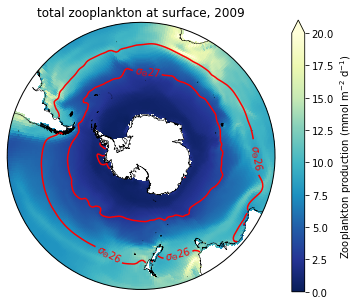

In [19]:
fig = plt.figure(figsize=(6,5))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('total zooplankton at surface, 2009')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field* 864., # convert to mmol/m2/d
                 vmin=0, vmax=20, 
                 cmap='YlGnBu_r',
                 transform=ccrs.PlateCarree())

pci=ax.contour(lons_sh2, lats_sh2, field2, 
                 levels=[26,27], 
                 colors='red',
                 transform=ccrs.PlateCarree())
fmt = {}
strs = ['${\sigma}_{\Theta}$26', '${\sigma}_{\Theta}$27']
for l, s in zip(pci.levels, strs):
    fmt[l] = s
ax.clabel(pci, pci.levels, inline=True, fmt=fmt, fontsize=10)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Zooplankton production (mmol m$^{-2}$ d$^{-1}$)')

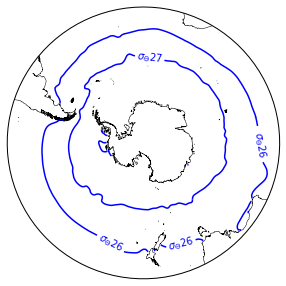

In [20]:
fig = plt.figure(figsize=(6,5))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
#ax.set_title('total zooplankton at surface, 2009')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lon, lat, 
#                  field, vmin=0, vmax=3, 
#                  cmap='YlGnBu_r',
#                  transform=ccrs.PlateCarree())

pci=ax.contour(lons_sh2, lats_sh2, 
                 field2, 
                 levels=[26,27], 
                 colors='blue',
                 transform=ccrs.PlateCarree())
fmt = {}
strs = ['${\sigma}_{\Theta}$26', '${\sigma}_{\Theta}$27']
for l, s in zip(pci.levels, strs):
    fmt[l] = s
ax.clabel(pci, pci.levels, inline=True, fmt=fmt, fontsize=10);
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Zooplankton biomass (mmol m$^{-3}$)')

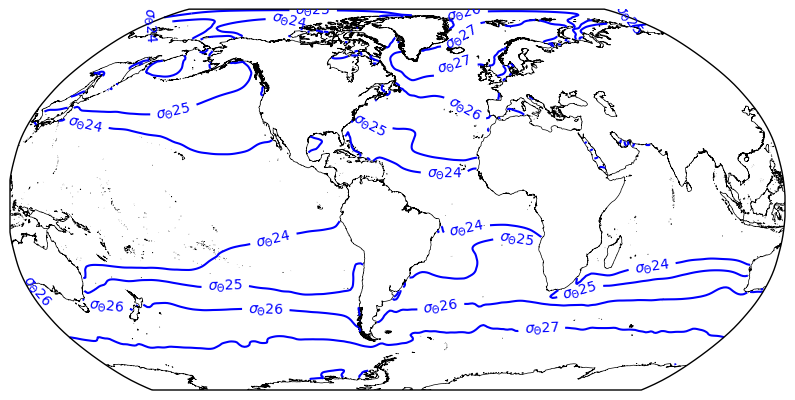

In [44]:
fig = plt.figure(figsize=(10,5))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
#ax.set_title('total zooplankton at surface, 2009')
lon2,lat2,field2 = adjust_pop_grid(lons, lats, sigma)

ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lon, lat, 
#                  field, vmin=0, vmax=3, 
#                  cmap='YlGnBu_r',
#                  transform=ccrs.PlateCarree())

pci=ax.contour(lon2, lat2, 
                 field2, 
                 levels=[24,25,26,27], 
                 colors='blue',
                 transform=ccrs.PlateCarree())
fmt = {}
strs = ['${\sigma}_{\Theta}$24','${\sigma}_{\Theta}$25','${\sigma}_{\Theta}$26', '${\sigma}_{\Theta}$27']
for l, s in zip(pci.levels, strs):
    fmt[l] = s
ax.clabel(pci, pci.levels, inline=True, fmt=fmt, fontsize=10);
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Zooplankton biomass (mmol m$^{-3}$)')

### Get SAM indices

In [21]:
csv_file = '/glade/work/kristenk/SAM_index/SAM_indices.csv'
sam_indices = pd.read_csv(csv_file, header=None)
sam_indices.columns = ['year', 'ANN', 'AUT' , 'WIN', 'SPR', 'SUM']
sam_indices

,year,ANN,AUT,WIN,SPR,SUM
0,1957,-4.24,-2.52,-0.68,-3.55,-2.52
1,1958,-1.27,-2.97,-0.92,1.42,1.12
2,1959,0.47,-0.94,-1.22,3.20,0.31
3,1960,1.52,0.74,0.32,1.00,-0.08
4,1961,1.22,0.48,0.93,0.85,2.19
...,...,...,...,...,...,...
58,2015,4.13,1.43,3.19,1.75,2.19
59,2016,1.67,1.64,1.49,-0.31,-1.75
60,2017,1.67,1.34,1.15,1.42,2.33
61,2018,1.96,-0.81,-0.76,3.92,1.43


In [22]:
ann_sam = sam_indices.ANN.values
time_sam = sam_indices.year.values

na = np.newaxis
da_sam = ann_sam[:,na,na]
da_sam = xr.DataArray(da_sam, dims=('time','lat','lon'))

#just get the overlapping timeperiod with the model
da_sam = da_sam.isel(time=slice(42,62)).squeeze()

### make timeseries of means between sigma-theta 26 an 27


In [52]:
ts_boxes_26to27 = xr.Dataset({v: ds[v] for v in ['time']})

masked = ds['x_graze_zoo1_zint'].where(sigma26to27>0.)
ts_boxes_26to27['x_graze_zoo1_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['x_graze_zoo2_zint'].where(sigma26to27>0.)
ts_boxes_26to27['x_graze_zoo2_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['x_graze_zoo3_zint'].where(sigma26to27>0.)
ts_boxes_26to27['x_graze_zoo3_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['x_graze_zoo4_zint'].where(sigma26to27>0.)
ts_boxes_26to27['x_graze_zoo4_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['photoC_TOT_zint'].where(sigma26to27>0.)
ts_boxes_26to27['photoC_TOT_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['photoC_diat_zint'].where(sigma26to27>0.)
ts_boxes_26to27['photoC_diat_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['z-ratio'].where(sigma26to27>0.)
ts_boxes_26to27['z-ratio'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()

masked = ds['TOT_zoo_prod_zint'].where(sigma26to27>0.)
ts_boxes_26to27['TOT_zoo_prod_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

ts_boxes_26to27['time']=years

### Make means of integrated biomass pools

In [24]:
ds_SAZ_means = xr. Dataset()
ds_SAZ_means['TOT_zoo_prod_zint'] = ts_boxes_26to27['TOT_zoo_prod_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_SAZ_means['photoC_TOT_zint'] = ts_boxes_26to27['photoC_TOT_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_SAZ_means['x_graze_zoo1_zint'] = ts_boxes_26to27['x_graze_zoo1_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_SAZ_means['x_graze_zoo2_zint'] = ts_boxes_26to27['x_graze_zoo2_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_SAZ_means['x_graze_zoo3_zint'] = ts_boxes_26to27['x_graze_zoo3_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_SAZ_means['x_graze_zoo4_zint'] = ts_boxes_26to27['x_graze_zoo4_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_SAZ_means['photoC_diat_zint'] = ts_boxes_26to27['photoC_diat_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_SAZ_means['z-ratio'] = ts_boxes_26to27['z-ratio'].isel(time=slice(2,tlen)).mean(dim='time')

### Make anomalies

In [25]:
ds_SAZ_anoms = xr. Dataset()
ds_SAZ_anoms['photoC_TOT_zint'] = ts_boxes_26to27['photoC_TOT_zint'].isel(time=slice(2,tlen)) - ds_SAZ_means['photoC_TOT_zint']
ds_SAZ_anoms['photoC_diat_zint'] = ts_boxes_26to27['photoC_diat_zint'].isel(time=slice(2,tlen)) - ds_SAZ_means['photoC_diat_zint']
ds_SAZ_anoms['TOT_zoo_prod_zint'] = ts_boxes_26to27['TOT_zoo_prod_zint'].isel(time=slice(2,tlen)) - ds_SAZ_means['TOT_zoo_prod_zint']
ds_SAZ_anoms['z-ratio'] = ts_boxes_26to27['z-ratio'].isel(time=slice(2,tlen)) - ds_SAZ_means['z-ratio']
ds_SAZ_anoms['x_graze_zoo4_zint'] = ts_boxes_26to27['x_graze_zoo4_zint'].isel(time=slice(2,tlen)) - ds_SAZ_means['x_graze_zoo4_zint']
ds_SAZ_anoms['x_graze_zoo3_zint'] = ts_boxes_26to27['x_graze_zoo3_zint'].isel(time=slice(2,tlen)) - ds_SAZ_means['x_graze_zoo3_zint']
ds_SAZ_anoms['x_graze_zoo2_zint'] = ts_boxes_26to27['x_graze_zoo2_zint'].isel(time=slice(2,tlen)) - ds_SAZ_means['x_graze_zoo2_zint']
ds_SAZ_anoms['x_graze_zoo1_zint'] = ts_boxes_26to27['x_graze_zoo1_zint'].isel(time=slice(2,tlen)) - ds_SAZ_means['x_graze_zoo1_zint']
ds_SAZ_anoms['SAM'] = da_sam.isel(time=slice(2,tlen))
ds_SAZ_anoms['time'] = ts_boxes_26to27['time'].isel(time=slice(2,tlen))

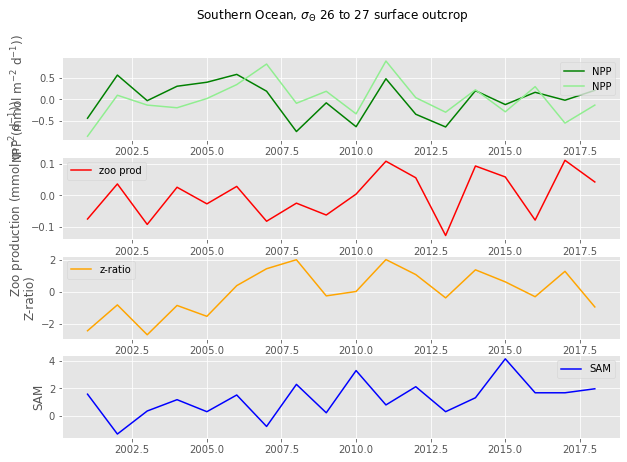

In [26]:
style.use('ggplot')
fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(10,7))
fig.suptitle('Southern Ocean, ${\sigma}_{\Theta}$ 26 to 27 surface outcrop')

ax[0].set_ylabel('NPP (mmol m$^{-2}$ d$^{-1}$))')
ax[0].plot(ds_SAZ_anoms['time'], 
         ds_SAZ_anoms['photoC_TOT_zint'], 
         color='green', label='NPP')
ax[0].plot(ts_boxes_26to27['time'].isel(time=slice(2,tlen)), 
         ts_boxes_26to27['photoC_diat_zint'].isel(time=slice(2,tlen)) - ds_SAZ_means.photoC_diat_zint, 
         color='lightgreen', label='NPP')
ax[0].legend()

ax[1].plot(ts_boxes_26to27['time'].isel(time=slice(2,tlen)), 
         ts_boxes_26to27['TOT_zoo_prod_zint'].isel(time=slice(2,tlen)) - ds_SAZ_means.TOT_zoo_prod_zint, 
         color='red', label='zoo prod')
ax[1].set_ylabel('Zoo production (mmol m$^{-2}$ d$^{-1}$))')
ax[1].legend()

ax[2].plot(ts_boxes_26to27['time'].isel(time=slice(2,tlen)), 
         ts_boxes_26to27['z-ratio'].isel(time=slice(2,tlen)) - ds_SAZ_means['z-ratio'], 
         color='orange', label='z-ratio')
ax[2].set_ylabel('Z-ratio)')
ax[2].legend()

ax[3].plot(ds_SAZ_anoms['time'], 
         ds_SAZ_anoms['SAM'], 
         color='blue', label='SAM')
ax[3].set_ylabel('SAM')
ax[3].legend();

### make timeseries of means for sigma-theta >27


In [27]:
ts_boxes_gt27 = xr.Dataset({v: ds[v] for v in ['time']})

masked = ds['x_graze_zoo1_zint'].where(sigma_gt27>0.)
ts_boxes_gt27['x_graze_zoo1_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['x_graze_zoo2_zint'].where(sigma_gt27>0.)
ts_boxes_gt27['x_graze_zoo2_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['x_graze_zoo3_zint'].where(sigma_gt27>0.)
ts_boxes_gt27['x_graze_zoo3_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['x_graze_zoo4_zint'].where(sigma_gt27>0.)
ts_boxes_gt27['x_graze_zoo4_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['photoC_TOT_zint'].where(sigma_gt27>0.)
ts_boxes_gt27['photoC_TOT_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['photoC_diat_zint'].where(sigma_gt27>0.)
ts_boxes_gt27['photoC_diat_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['z-ratio'].where(sigma_gt27>0.)
ts_boxes_gt27['z-ratio'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()

masked = ds['TOT_zoo_prod_zint'].where(sigma_gt27>0.)
ts_boxes_gt27['TOT_zoo_prod_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

ts_boxes_gt27['time']=years

### Make means for AZ

In [28]:
ds_AZ_means = xr. Dataset()
ds_AZ_means['TOT_zoo_prod_zint'] = ts_boxes_gt27['TOT_zoo_prod_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_AZ_means['photoC_TOT_zint'] = ts_boxes_gt27['photoC_TOT_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_AZ_means['x_graze_zoo1_zint'] = ts_boxes_gt27['x_graze_zoo1_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_AZ_means['x_graze_zoo2_zint'] = ts_boxes_gt27['x_graze_zoo2_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_AZ_means['x_graze_zoo3_zint'] = ts_boxes_gt27['x_graze_zoo3_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_AZ_means['x_graze_zoo4_zint'] = ts_boxes_gt27['x_graze_zoo4_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_AZ_means['photoC_diat_zint'] = ts_boxes_gt27['photoC_diat_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_AZ_means['z-ratio'] = ts_boxes_gt27['z-ratio'].isel(time=slice(2,tlen)).mean(dim='time')

### Make anomalies

In [29]:
ds_AZ_anoms = xr. Dataset()
ds_AZ_anoms['photoC_TOT_zint'] = ts_boxes_gt27['photoC_TOT_zint'].isel(time=slice(2,tlen)) - ds_AZ_means['photoC_TOT_zint']
ds_AZ_anoms['photoC_diat_zint'] = ts_boxes_gt27['photoC_diat_zint'].isel(time=slice(2,tlen)) - ds_AZ_means['photoC_diat_zint']
ds_AZ_anoms['TOT_zoo_prod_zint'] = ts_boxes_gt27['TOT_zoo_prod_zint'].isel(time=slice(2,tlen)) - ds_AZ_means['TOT_zoo_prod_zint']
ds_AZ_anoms['z-ratio'] = ts_boxes_gt27['z-ratio'].isel(time=slice(2,tlen)) - ds_AZ_means['z-ratio']
ds_AZ_anoms['x_graze_zoo4_zint'] = ts_boxes_gt27['x_graze_zoo4_zint'].isel(time=slice(2,tlen)) - ds_AZ_means['x_graze_zoo4_zint']
ds_AZ_anoms['x_graze_zoo3_zint'] = ts_boxes_gt27['x_graze_zoo3_zint'].isel(time=slice(2,tlen)) - ds_AZ_means['x_graze_zoo3_zint']
ds_AZ_anoms['x_graze_zoo2_zint'] = ts_boxes_gt27['x_graze_zoo2_zint'].isel(time=slice(2,tlen)) - ds_AZ_means['x_graze_zoo2_zint']
ds_AZ_anoms['x_graze_zoo1_zint'] = ts_boxes_gt27['x_graze_zoo1_zint'].isel(time=slice(2,tlen)) - ds_AZ_means['x_graze_zoo1_zint']
ds_AZ_anoms['SAM'] = da_sam.isel(time=slice(2,tlen))
ds_AZ_anoms['time'] = ts_boxes_gt27['time'].isel(time=slice(2,tlen))

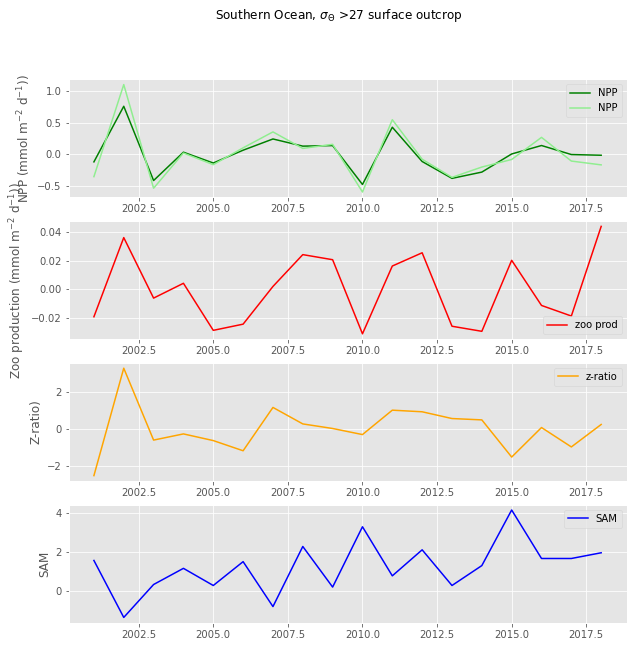

In [30]:
style.use('ggplot')
fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(10,10))
fig.suptitle('Southern Ocean, ${\sigma}_{\Theta}$ >27 surface outcrop')

ax[0].set_ylabel('NPP (mmol m$^{-2}$ d$^{-1}$))')
ax[0].plot(ds_AZ_anoms['time'], 
         ds_AZ_anoms['photoC_TOT_zint'], 
         color='green', label='NPP')
ax[0].plot(ts_boxes_gt27['time'].isel(time=slice(2,tlen)), 
         ts_boxes_gt27['photoC_diat_zint'].isel(time=slice(2,tlen)) - ds_AZ_means.photoC_diat_zint, 
         color='lightgreen', label='NPP')
ax[0].legend()

ax[1].plot(ts_boxes_gt27['time'].isel(time=slice(2,tlen)), 
         ts_boxes_gt27['TOT_zoo_prod_zint'].isel(time=slice(2,tlen)) - ds_AZ_means.TOT_zoo_prod_zint, 
         color='red', label='zoo prod')
ax[1].set_ylabel('Zoo production (mmol m$^{-2}$ d$^{-1}$))')
ax[1].legend()

ax[2].plot(ts_boxes_gt27['time'].isel(time=slice(2,tlen)), 
         ts_boxes_gt27['z-ratio'].isel(time=slice(2,tlen)) - ds_AZ_means['z-ratio'], 
         color='orange', label='z-ratio')
ax[2].set_ylabel('Z-ratio)')
ax[2].legend()

ax[3].plot(ds_AZ_anoms['time'], 
         ds_AZ_anoms['SAM'], 
         color='blue', label='SAM')
ax[3].set_ylabel('SAM')
ax[3].legend();

### Make timeseries for sigma 25 to 26

In [56]:
ts_boxes_25to26 = xr.Dataset({v: ds[v] for v in ['time']})

masked = ds['x_graze_zoo1_zint'].where(sigma25to26>0.)
ts_boxes_25to26['x_graze_zoo1_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['x_graze_zoo2_zint'].where(sigma25to26>0.)
ts_boxes_25to26['x_graze_zoo2_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['x_graze_zoo3_zint'].where(sigma25to26>0.)
ts_boxes_25to26['x_graze_zoo3_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['x_graze_zoo4_zint'].where(sigma25to26>0.)
ts_boxes_25to26['x_graze_zoo4_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['photoC_TOT_zint'].where(sigma25to26>0.)
ts_boxes_25to26['photoC_TOT_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['photoC_diat_zint'].where(sigma25to26>0.)
ts_boxes_25to26['photoC_diat_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['z-ratio'].where(sigma_gt27>0.)
ts_boxes_25to26['z-ratio'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()

masked = ds['TOT_zoo_prod_zint'].where(sigma25to26>0.)
ts_boxes_25to26['TOT_zoo_prod_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

ts_boxes_25to26['time']=years

In [57]:
ds_25to26_means = xr. Dataset()
ds_25to26_means['TOT_zoo_prod_zint'] = ts_boxes_25to26['TOT_zoo_prod_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_25to26_means['photoC_TOT_zint'] = ts_boxes_25to26['photoC_TOT_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_25to26_means['x_graze_zoo1_zint'] = ts_boxes_25to26['x_graze_zoo1_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_25to26_means['x_graze_zoo2_zint'] = ts_boxes_25to26['x_graze_zoo2_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_25to26_means['x_graze_zoo3_zint'] = ts_boxes_25to26['x_graze_zoo3_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_25to26_means['x_graze_zoo4_zint'] = ts_boxes_25to26['x_graze_zoo4_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_25to26_means['photoC_diat_zint'] = ts_boxes_25to26['photoC_diat_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_25to26_means['z-ratio'] = ts_boxes_25to26['z-ratio'].isel(time=slice(2,tlen)).mean(dim='time')

In [58]:
ds_25to26_anoms = xr. Dataset()
ds_25to26_anoms['photoC_TOT_zint'] = ts_boxes_25to26['photoC_TOT_zint'].isel(time=slice(2,tlen)) - ds_25to26_means['photoC_TOT_zint']
ds_25to26_anoms['photoC_diat_zint'] = ts_boxes_25to26['photoC_diat_zint'].isel(time=slice(2,tlen)) - ds_25to26_means['photoC_diat_zint']
ds_25to26_anoms['TOT_zoo_prod_zint'] = ts_boxes_25to26['TOT_zoo_prod_zint'].isel(time=slice(2,tlen)) - ds_25to26_means['TOT_zoo_prod_zint']
ds_25to26_anoms['z-ratio'] = ts_boxes_25to26['z-ratio'].isel(time=slice(2,tlen)) - ds_25to26_means['z-ratio']
ds_25to26_anoms['x_graze_zoo4_zint'] = ts_boxes_25to26['x_graze_zoo4_zint'].isel(time=slice(2,tlen)) - ds_25to26_means['x_graze_zoo4_zint']
ds_25to26_anoms['x_graze_zoo3_zint'] = ts_boxes_25to26['x_graze_zoo3_zint'].isel(time=slice(2,tlen)) - ds_25to26_means['x_graze_zoo3_zint']
ds_25to26_anoms['x_graze_zoo2_zint'] = ts_boxes_25to26['x_graze_zoo2_zint'].isel(time=slice(2,tlen)) - ds_25to26_means['x_graze_zoo2_zint']
ds_25to26_anoms['x_graze_zoo1_zint'] = ts_boxes_25to26['x_graze_zoo1_zint'].isel(time=slice(2,tlen)) - ds_25to26_means['x_graze_zoo1_zint']
ds_25to26_anoms['SAM'] = da_sam.isel(time=slice(2,tlen))
ds_25to26_anoms['time'] = ts_boxes_25to26['time'].isel(time=slice(2,tlen))

### make timeseries for 24 to 25 sigma

In [65]:
ts_boxes_24to25 = xr.Dataset({v: ds[v] for v in ['time']})

masked = ds['x_graze_zoo1_zint'].where(sigma24to25>0.)
ts_boxes_24to25['x_graze_zoo1_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['x_graze_zoo2_zint'].where(sigma24to25>0.)
ts_boxes_24to25['x_graze_zoo2_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['x_graze_zoo3_zint'].where(sigma24to25>0.)
ts_boxes_24to25['x_graze_zoo3_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['x_graze_zoo4_zint'].where(sigma24to25>0.)
ts_boxes_24to25['x_graze_zoo4_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['photoC_TOT_zint'].where(sigma24to25>0.)
ts_boxes_24to25['photoC_TOT_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['photoC_diat_zint'].where(sigma24to25>0.)
ts_boxes_24to25['photoC_diat_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

masked = ds['z-ratio'].where(sigma24to25>0.)
ts_boxes_24to25['z-ratio'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()

masked = ds['TOT_zoo_prod_zint'].where(sigma24to25>0.)
ts_boxes_24to25['TOT_zoo_prod_zint'] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute() * 864.

ts_boxes_24to25['time']=years

In [66]:
ds_24to25_means = xr. Dataset()
ds_24to25_means['TOT_zoo_prod_zint'] = ts_boxes_24to25['TOT_zoo_prod_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_24to25_means['photoC_TOT_zint'] = ts_boxes_24to25['photoC_TOT_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_24to25_means['x_graze_zoo1_zint'] = ts_boxes_24to25['x_graze_zoo1_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_24to25_means['x_graze_zoo2_zint'] = ts_boxes_24to25['x_graze_zoo2_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_24to25_means['x_graze_zoo3_zint'] = ts_boxes_24to25['x_graze_zoo3_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_24to25_means['x_graze_zoo4_zint'] = ts_boxes_24to25['x_graze_zoo4_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_24to25_means['photoC_diat_zint'] = ts_boxes_24to25['photoC_diat_zint'].isel(time=slice(2,tlen)).mean(dim='time')
ds_24to25_means['z-ratio'] = ts_boxes_24to25['z-ratio'].isel(time=slice(2,tlen)).mean(dim='time')

In [67]:
ds_24to25_anoms = xr. Dataset()
ds_24to25_anoms['photoC_TOT_zint'] = ts_boxes_24to25['photoC_TOT_zint'].isel(time=slice(2,tlen)) - ds_24to25_means['photoC_TOT_zint']
ds_24to25_anoms['photoC_diat_zint'] = ts_boxes_24to25['photoC_diat_zint'].isel(time=slice(2,tlen)) - ds_24to25_means['photoC_diat_zint']
ds_24to25_anoms['TOT_zoo_prod_zint'] = ts_boxes_24to25['TOT_zoo_prod_zint'].isel(time=slice(2,tlen)) - ds_24to25_means['TOT_zoo_prod_zint']
ds_24to25_anoms['z-ratio'] = ts_boxes_24to25['z-ratio'].isel(time=slice(2,tlen)) - ds_24to25_means['z-ratio']
ds_24to25_anoms['x_graze_zoo4_zint'] = ts_boxes_24to25['x_graze_zoo4_zint'].isel(time=slice(2,tlen)) - ds_24to25_means['x_graze_zoo4_zint']
ds_24to25_anoms['x_graze_zoo3_zint'] = ts_boxes_24to25['x_graze_zoo3_zint'].isel(time=slice(2,tlen)) - ds_24to25_means['x_graze_zoo3_zint']
ds_24to25_anoms['x_graze_zoo2_zint'] = ts_boxes_24to25['x_graze_zoo2_zint'].isel(time=slice(2,tlen)) - ds_24to25_means['x_graze_zoo2_zint']
ds_24to25_anoms['x_graze_zoo1_zint'] = ts_boxes_24to25['x_graze_zoo1_zint'].isel(time=slice(2,tlen)) - ds_24to25_means['x_graze_zoo1_zint']
ds_24to25_anoms['SAM'] = da_sam.isel(time=slice(2,tlen))
ds_24to25_anoms['time'] = ts_boxes_24to25['time'].isel(time=slice(2,tlen))

### Correlation grids for SAZ

In [59]:
#NPP, DiatNPP, zoo_pro, z-ratio, SAM
SAZ_correlations = np.zeros([5,5])

labels = ['NPP', 'diatNPP', 'ZooProd', 'z-ratio','SAM']
variables = ['photoC_TOT_zint', 'photoC_diat_zint', 'TOT_zoo_prod_zint', 'z-ratio','SAM']
i=0
j=0

for var1 in variables:  #i loop
    
    #print(j)
    
    for var2 in variables: #j loop
        
        print(i,j, var1, var2)
    
        slope, intercept, r_value, p_value, std_err = stats.linregress(ds_SAZ_anoms[var1],
                                                               ds_SAZ_anoms[var2])
        SAZ_correlations[i,j] = r_value
    
        i = i +1
        
    j = j+1
    i=0
    

SAZ_correlations = xr.DataArray(SAZ_correlations) 

0 0 photoC_TOT_zint photoC_TOT_zint
1 0 photoC_TOT_zint photoC_diat_zint
2 0 photoC_TOT_zint TOT_zoo_prod_zint
3 0 photoC_TOT_zint z-ratio
4 0 photoC_TOT_zint SAM
0 1 photoC_diat_zint photoC_TOT_zint
1 1 photoC_diat_zint photoC_diat_zint
2 1 photoC_diat_zint TOT_zoo_prod_zint
3 1 photoC_diat_zint z-ratio
4 1 photoC_diat_zint SAM
0 2 TOT_zoo_prod_zint photoC_TOT_zint
1 2 TOT_zoo_prod_zint photoC_diat_zint
2 2 TOT_zoo_prod_zint TOT_zoo_prod_zint
3 2 TOT_zoo_prod_zint z-ratio
4 2 TOT_zoo_prod_zint SAM
0 3 z-ratio photoC_TOT_zint
1 3 z-ratio photoC_diat_zint
2 3 z-ratio TOT_zoo_prod_zint
3 3 z-ratio z-ratio
4 3 z-ratio SAM
0 4 SAM photoC_TOT_zint
1 4 SAM photoC_diat_zint
2 4 SAM TOT_zoo_prod_zint
3 4 SAM z-ratio
4 4 SAM SAM


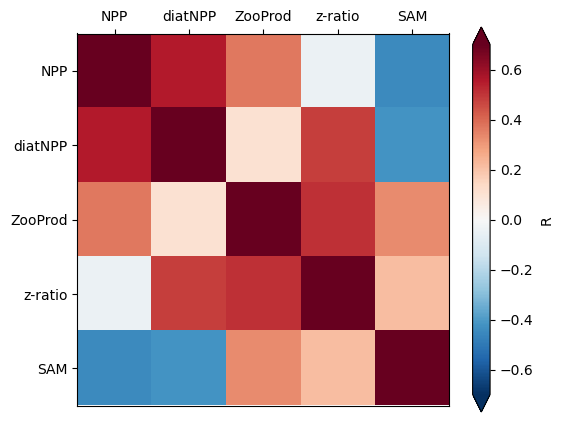

In [60]:
style.use('default')

fig = plt.figure(figsize=(6,5))

ax = fig.add_subplot(1,1,1)

#ax.set_title('SSH / surface Chl correlation')
pc=ax.imshow(SAZ_correlations,cmap='RdBu_r',vmax=0.7,vmin=-0.7)
# for i in range(len(ds_r_vals.ssh_band)):
#     for j in range(len(ds_r_vals.month)):
#         if ds_p_vals.totChl_surf[i,j].values< 0.05:
#             ax.scatter(j, i,
#                        color="black", marker="*")

ax.xaxis.tick_top()
ax.set_xticks(np.arange(5))
ax.set_yticks(np.arange(5))
# ... and label them with the respective list entries
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

### Correlation grid for AZ

In [61]:
#NPP, DiatNPP, zoo_pro, z-ratio, SAM
AZ_correlations = np.zeros([5,5])

labels = ['NPP', 'diatNPP', 'ZooProd', 'z-ratio','SAM']
variables = ['photoC_TOT_zint', 'photoC_diat_zint', 'TOT_zoo_prod_zint', 'z-ratio','SAM']
i=0
j=0

for var1 in variables:  #i loop
    
    #print(j)
    
    for var2 in variables: #j loop
        
        print(i,j, var1, var2)
    
        slope, intercept, r_value, p_value, std_err = stats.linregress(ds_AZ_anoms[var1],
                                                               ds_AZ_anoms[var2])
        AZ_correlations[i,j] = r_value
    
        i = i +1
        
    j = j+1
    i=0
    

    

0 0 photoC_TOT_zint photoC_TOT_zint
1 0 photoC_TOT_zint photoC_diat_zint
2 0 photoC_TOT_zint TOT_zoo_prod_zint
3 0 photoC_TOT_zint z-ratio
4 0 photoC_TOT_zint SAM
0 1 photoC_diat_zint photoC_TOT_zint
1 1 photoC_diat_zint photoC_diat_zint
2 1 photoC_diat_zint TOT_zoo_prod_zint
3 1 photoC_diat_zint z-ratio
4 1 photoC_diat_zint SAM
0 2 TOT_zoo_prod_zint photoC_TOT_zint
1 2 TOT_zoo_prod_zint photoC_diat_zint
2 2 TOT_zoo_prod_zint TOT_zoo_prod_zint
3 2 TOT_zoo_prod_zint z-ratio
4 2 TOT_zoo_prod_zint SAM
0 3 z-ratio photoC_TOT_zint
1 3 z-ratio photoC_diat_zint
2 3 z-ratio TOT_zoo_prod_zint
3 3 z-ratio z-ratio
4 3 z-ratio SAM
0 4 SAM photoC_TOT_zint
1 4 SAM photoC_diat_zint
2 4 SAM TOT_zoo_prod_zint
3 4 SAM z-ratio
4 4 SAM SAM


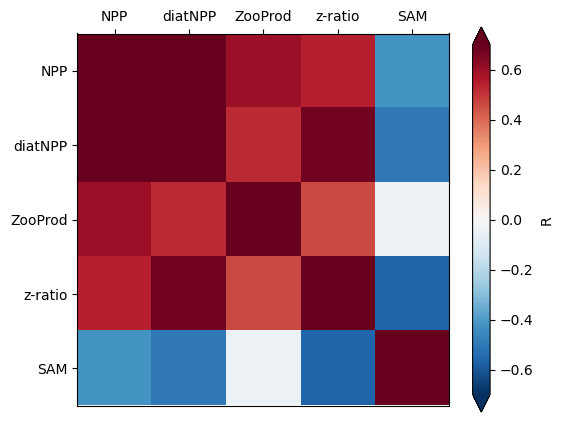

In [62]:
style.use('default')

fig = plt.figure(figsize=(6,5))

ax = fig.add_subplot(1,1,1)

#ax.set_title('SSH / surface Chl correlation')
pc=ax.imshow(AZ_correlations,cmap='RdBu_r',vmax=0.7,vmin=-0.7)
# for i in range(len(ds_r_vals.ssh_band)):
#     for j in range(len(ds_r_vals.month)):
#         if ds_p_vals.totChl_surf[i,j].values< 0.05:
#             ax.scatter(j, i,
#                        color="black", marker="*")

ax.xaxis.tick_top()
ax.set_xticks(np.arange(5))
ax.set_yticks(np.arange(5))
# ... and label them with the respective list entries
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

### Correlation grid for 25 to 25 sigma

In [63]:
#NPP, DiatNPP, zoo_pro, z-ratio, SAM
sig25to26_correlations = np.zeros([5,5])

labels = ['NPP', 'diatNPP', 'ZooProd', 'z-ratio','SAM']
variables = ['photoC_TOT_zint', 'photoC_diat_zint', 'TOT_zoo_prod_zint', 'z-ratio','SAM']
i=0
j=0

for var1 in variables:  #i loop
    
    #print(j)
    
    for var2 in variables: #j loop
        
        print(i,j, var1, var2)
    
        slope, intercept, r_value, p_value, std_err = stats.linregress(ds_25to26_anoms[var1],
                                                               ds_25to26_anoms[var2])
        sig25to26_correlations[i,j] = r_value
    
        i = i +1
        
    j = j+1
    i=0
    

    

0 0 photoC_TOT_zint photoC_TOT_zint
1 0 photoC_TOT_zint photoC_diat_zint
2 0 photoC_TOT_zint TOT_zoo_prod_zint
3 0 photoC_TOT_zint z-ratio
4 0 photoC_TOT_zint SAM
0 1 photoC_diat_zint photoC_TOT_zint
1 1 photoC_diat_zint photoC_diat_zint
2 1 photoC_diat_zint TOT_zoo_prod_zint
3 1 photoC_diat_zint z-ratio
4 1 photoC_diat_zint SAM
0 2 TOT_zoo_prod_zint photoC_TOT_zint
1 2 TOT_zoo_prod_zint photoC_diat_zint
2 2 TOT_zoo_prod_zint TOT_zoo_prod_zint
3 2 TOT_zoo_prod_zint z-ratio
4 2 TOT_zoo_prod_zint SAM
0 3 z-ratio photoC_TOT_zint
1 3 z-ratio photoC_diat_zint
2 3 z-ratio TOT_zoo_prod_zint
3 3 z-ratio z-ratio
4 3 z-ratio SAM
0 4 SAM photoC_TOT_zint
1 4 SAM photoC_diat_zint
2 4 SAM TOT_zoo_prod_zint
3 4 SAM z-ratio
4 4 SAM SAM


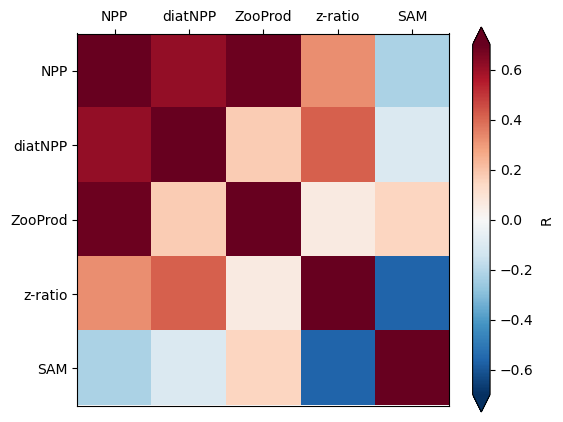

In [64]:
style.use('default')

fig = plt.figure(figsize=(6,5))

ax = fig.add_subplot(1,1,1)

#ax.set_title('SSH / surface Chl correlation')
pc=ax.imshow(sig25to26_correlations,cmap='RdBu_r',vmax=0.7,vmin=-0.7)
# for i in range(len(ds_r_vals.ssh_band)):
#     for j in range(len(ds_r_vals.month)):
#         if ds_p_vals.totChl_surf[i,j].values< 0.05:
#             ax.scatter(j, i,
#                        color="black", marker="*")

ax.xaxis.tick_top()
ax.set_xticks(np.arange(5))
ax.set_yticks(np.arange(5))
# ... and label them with the respective list entries
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

In [68]:
#NPP, DiatNPP, zoo_pro, z-ratio, SAM
sig24to25_correlations = np.zeros([5,5])

labels = ['NPP', 'diatNPP', 'ZooProd', 'z-ratio','SAM']
variables = ['photoC_TOT_zint', 'photoC_diat_zint', 'TOT_zoo_prod_zint', 'z-ratio','SAM']
i=0
j=0

for var1 in variables:  #i loop
    
    #print(j)
    
    for var2 in variables: #j loop
        
        print(i,j, var1, var2)
    
        slope, intercept, r_value, p_value, std_err = stats.linregress(ds_24to25_anoms[var1],
                                                               ds_24to25_anoms[var2])
        sig24to25_correlations[i,j] = r_value
    
        i = i +1
        
    j = j+1
    i=0
    

    

0 0 photoC_TOT_zint photoC_TOT_zint
1 0 photoC_TOT_zint photoC_diat_zint
2 0 photoC_TOT_zint TOT_zoo_prod_zint
3 0 photoC_TOT_zint z-ratio
4 0 photoC_TOT_zint SAM
0 1 photoC_diat_zint photoC_TOT_zint
1 1 photoC_diat_zint photoC_diat_zint
2 1 photoC_diat_zint TOT_zoo_prod_zint
3 1 photoC_diat_zint z-ratio
4 1 photoC_diat_zint SAM
0 2 TOT_zoo_prod_zint photoC_TOT_zint
1 2 TOT_zoo_prod_zint photoC_diat_zint
2 2 TOT_zoo_prod_zint TOT_zoo_prod_zint
3 2 TOT_zoo_prod_zint z-ratio
4 2 TOT_zoo_prod_zint SAM
0 3 z-ratio photoC_TOT_zint
1 3 z-ratio photoC_diat_zint
2 3 z-ratio TOT_zoo_prod_zint
3 3 z-ratio z-ratio
4 3 z-ratio SAM
0 4 SAM photoC_TOT_zint
1 4 SAM photoC_diat_zint
2 4 SAM TOT_zoo_prod_zint
3 4 SAM z-ratio
4 4 SAM SAM


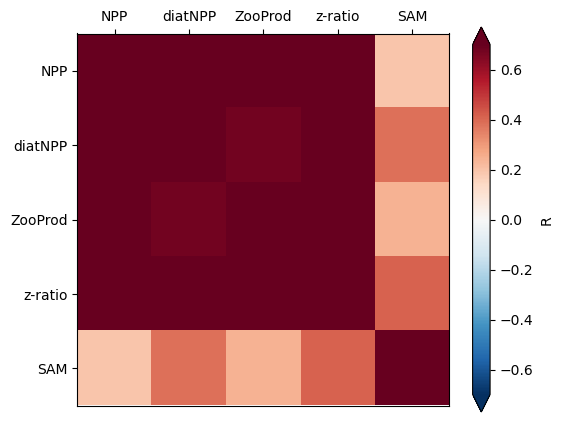

In [69]:
style.use('default')

fig = plt.figure(figsize=(6,5))

ax = fig.add_subplot(1,1,1)

#ax.set_title('SSH / surface Chl correlation')
pc=ax.imshow(sig24to25_correlations,cmap='RdBu_r',vmax=0.7,vmin=-0.7)
# for i in range(len(ds_r_vals.ssh_band)):
#     for j in range(len(ds_r_vals.month)):
#         if ds_p_vals.totChl_surf[i,j].values< 0.05:
#             ax.scatter(j, i,
#                        color="black", marker="*")

ax.xaxis.tick_top()
ax.set_xticks(np.arange(5))
ax.set_yticks(np.arange(5))
# ... and label them with the respective list entries
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')